In [1]:
! pip install --quiet gensim

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [14]:
import pandas as pd

yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=0.1)

In [15]:
from bs4 import BeautifulSoup
import re

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """

    token_pattern=r"(?u)\b\w\w+\b" #reexp obtained from sklearn countvectorizer documentation
    token_pattern = re.compile(token_pattern)
    tokens= token_pattern.findall(s)
    return tokens


To create the Count Vectorizer we will go through each documentin our corpus, clean it, tokenize it and then count how many times each word appears. This will be saved in a dictionary. We have a list of all the dictionaries and a list for all the words. 

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

indices=[] #features
values=[] #term frequency
matrix_seed=[] #vectorized matrix

for doc in yelps.text: #we go through each yelp
    tokens=tokenize(clean_yelp(doc)) #preprocess and tokenize each yelp
    features={}
    for token in tokens: #create a dictioanry with the frequency of each token
        if token not in features:
            features[token]=1
        else:
            features[token]+=1
    indices.extend(features.keys()) #add the tokens of each document to the features list
    values.append(features) #append the frequency dictionary to the value list

/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


From the list of all words we eliminate duplicates and we have a list of our vocabulary.

In [17]:
unique_indices=list(set(indices)) #obtain a list of unique words (all the vovabulary)

Last we build a list of lists which will contain the rows of our future matrix. Here we will fill with zeros the words that do not appear in our vocabulary.

In [5]:
for value in values: #fill the words of the vocabulary that don't appear in a document with 0
    row=[value.get(index,0) for index in unique_indices]
    matrix_seed.append(row) #append each row to our matrix

Now we use a sparce matrix structure to compress our matrix.

In [6]:
final_matrix= csr_matrix(matrix_seed) #compress our matrix into a sparce matrix format

# Create a count vectorizer, using the preprocessor and tokenizer from above
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD

To perform the dimension reduction we do a PCA of our matrix and take the first 100 dimensions.

In [7]:
svd=TruncatedSVD(n_components=100)
term_embedding=svd.fit(final_matrix)
truncated_matrix=svd.transform(final_matrix)

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [12]:
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 
cutoff=[0.1,0.15,0.20,0.30,0.5,0.75,0.90]
pred=[]
for cut in cutoff:
    pred.append(test_holdout_vectors(truncated_matrix,yelps.positive,int(cut*yelps.shape[0])))


/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

We test our Count Vectorizer to classify yelps reviews using a logistic regression. We use the provided function to see how the training size affects the accuracy of the results. We can see that it goes up but from 75% to 90% falls unexpectedly.

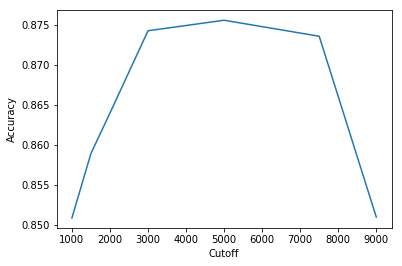

In [13]:
import matplotlib.pyplot as plt
cuts_number_samples=[int(cut*yelps.shape[0]) for cut in cutoff]
plt.plot(cuts_number_samples,pred)
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.show() #I do not understand why from 8000 to 9000 accuracy decreases... 

Now we will do the same as in the previous part but with the Word2Vec model from gensim library. In the first part we have not provided the sentences but we have just specified the parameters. Then we create the sentences by appending the tokenized documents to a list. Then we build the vocabular of our model and we train it.

In [5]:
from gensim.models import Word2Vec

model = Word2Vec(min_count=20,
                     window=2,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=4)

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!

# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 

/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [15]:
sentences=[]
for doc in yelps.text: #we go through each yelp
    tokens=tokenize(clean_yelp(doc)) #preprocess and tokenize each yelp
    sentences.append(tokens)

In [18]:
model.build_vocab(sentences,progress_per=1000)

In [50]:
model.train(sentences, total_examples=len(sentences), epochs=10, report_delay=1)

(3693654, 11211510)

In [ ]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

Now we can use the function provided to obtain the embeddings of the vectors and use them alongside the logistic regression.

In [61]:
w2v_emb=np.array([embed_w2v(t, model) for t in sentences])

In [63]:
cutoff=[0.1,0.15,0.20,0.30,0.5,0.75,0.90]
pred_w2v=[]
for cut in cutoff:
    pred_w2v.append(test_holdout_vectors(w2v_emb,yelps.positive,int(cut*yelps.shape[0])))

/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

In [6]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a


# use as follows: np.array([embed_w2v(t, w2v) for t in X])

We see that we obtain much better results than with the rather basic Count vectorizer but we also see that from 75% to 90% the accuracy does not improve.

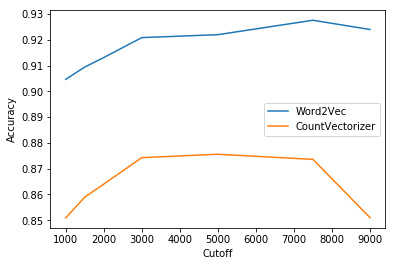

In [65]:
plt.plot(cuts_number_samples,pred_w2v, label='Word2Vec')
plt.plot(cuts_number_samples,pred, label='CountVectorizer')
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Now we will proceed to the the same but with tweeter data. First we use some regular expressions to clean the tweets. This includes removing mentions to other users, removing the hashtag symbol, removing the url's, etc.

In [7]:
import pandas as pd
import re
from functools import reduce
import spacy

nlp = spacy.load('en', disable=['parser', 'ner'])

pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    s = s.lower()
    _sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(_sub, pats, s)
    s = ' '.join(s.split()).strip()
    s=re.sub(r'@\w+','', s) #delete user references
    s=re.sub(r'#','', s) #delete hashtag symbol only, not the hashtag itself
    s=re.sub(r'https\S+','',s) #delete the url
    s=re.sub(r'RT','',s) #delete the RT
    s=re.sub(r'\n','',s) #delete the end of line indicators
    s=re.sub(r'[^\w\s]','',s) #delete all punctuation signs, needed??? Maybe we could remove only the : at the beginning of each tweet
    s=s.encode('ascii', 'ignore').decode('ascii') #delete all the emojis
    doc = nlp(s)
    s=" ".join([token.lemma_ for token in doc]) #lemmatizing using spacy

    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    return s

In [8]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 

with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [9]:
tweets=tweets.sample(n=10000)

Now we proceed in the exact same way as before with the Count vectorizer and the word2vec. (we should do a couple of functions instead of repeating the same code)

In [11]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

#LSA

indices_twitter=[] #features
values_twitter=[] #term frequency
matrix_seed_twitter=[] #vectorized matrix

for doc in tweets: #we go through each tweet
    tokens=tokenize(clean_twitter(doc)) #preprocess and tokenize each yelp
    features={}
    for token in tokens: #create a dictioanry with the frequency of each token
        if token not in features:
            features[token]=1
        else:
            features[token]+=1
    indices_twitter.extend(features.keys()) #add the tokens of each document to the features list
    values_twitter.append(features) #append the frequency dictionary to the value list

In [12]:
unique_indices_twitter=list(set(indices_twitter)) #obtain a list of unique words (all the vovabulary)    

In [19]:
for value in values_twitter: #fill the words of the vocabulary that don't appear in a document with 0
    row=[value.get(index,0) for index in unique_indices_twitter]
    matrix_seed_twitter.append(row) #append each row to our matrix

In [20]:
final_matrix_twitter= csr_matrix(matrix_seed_twitter) #compress our matrix into a sparce matrix format

In [21]:
svd=TruncatedSVD(n_components=100)
term_embedding_twitter=svd.fit(final_matrix_twitter)
truncated_matrix_twitter=svd.transform(final_matrix_twitter)

In [23]:
#Word2Vec
model_tweeter = Word2Vec(min_count=20,
                     window=2,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=4)

In [22]:
sentences_tweeter=[]
for doc in tweets: #we go through each yelp
    tokens=tokenize(clean_twitter(doc)) #preprocess and tokenize each yelp
    sentences_tweeter.append(tokens)


In [24]:
model_tweeter.build_vocab(sentences_tweeter,progress_per=1000)

In [25]:
model_tweeter.train(sentences_tweeter, total_examples=len(sentences_tweeter), epochs=10, report_delay=1)

(167415, 1118570)

In [26]:
w2v_emb_tweeter=np.array([embed_w2v(t, model_tweeter) for t in sentences_tweeter])

As tweeter data is unlabeled we cannot classify it like the yelps. However we can see how different words are using some functions of gensim package.

In [36]:
# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 
# 
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

model_tweeter.wv.most_similar(positive=["hillary"]) #Hillary is related with more "serious" words 
#such as government, court, order, president

[('post', 0.9998263120651245),
 ('government', 0.9998106360435486),
 ('president', 0.9998105764389038),
 ('soon', 0.9998037815093994),
 ('court', 0.9997957944869995),
 ('house', 0.9997901320457458),
 ('nyc', 0.9997888803482056),
 ('cop', 0.9997873306274414),
 ('next', 0.9997867941856384),
 ('order', 0.9997864961624146)]

In [39]:
model_tweeter.wv.most_similar(positive=["trump"])#Trump is related to more 'polemical' words such as attack, school or obama

[('this', 0.9998161792755127),
 ('http', 0.9997826814651489),
 ('there', 0.9997813701629639),
 ('obama', 0.9997813701629639),
 ('in', 0.9997805953025818),
 ('with', 0.9997712969779968),
 ('would', 0.9997676610946655),
 ('one', 0.9997662901878357),
 ('attack', 0.999763011932373),
 ('school', 0.9997629523277283)]

In [38]:
model_tweeter.wv.most_similar(positive=["trump"], negative=["hillary"], topn=5) #not really interesting results

[('to', 0.013594307005405426),
 ('be', 0.012139536440372467),
 ('of', 0.0111542958766222),
 ('PRON', 0.010115716606378555),
 ('the', 0.006917675957083702)]

In [35]:
#Which word is to trump as hillary is to president?... Child and government... Oh well, who would have guessed it, right?
model_tweeter.wv.most_similar(positive=["trump", "hillary"], negative=["president"], topn=3)

[('go', 0.9996809959411621),
 ('child', 0.9996645450592041),
 ('government', 0.9996488094329834)]

In [41]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

In [ ]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data